# Titanic Dataset Experiment
## Henry Salgado
### May 2025

In [194]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import dice_ml
from dice_ml import Dice
from dice_ml.utils import helpers
from sklearn.ensemble import RandomForestClassifier


Dataset variables can be found here: https://www.kaggle.com/c/titanic/data

In [163]:
import seaborn as sns
df = sns.load_dataset('titanic')
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [164]:
print(df.isnull().sum())

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


In [165]:
df = df.drop(columns=["deck"])
df = df.dropna()



In [166]:
df['sex'].value_counts()

male      453
female    259
Name: sex, dtype: int64

Let's one-hot encode categorical data 

In [167]:
df['sex'] = LabelEncoder().fit_transform(df['sex'])
df['embarked'] = LabelEncoder().fit_transform(df['embarked']) 


In [168]:
df['sex'].value_counts()

1    453
0    259
Name: sex, dtype: int64

In [169]:
X = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]
y = df['survived']

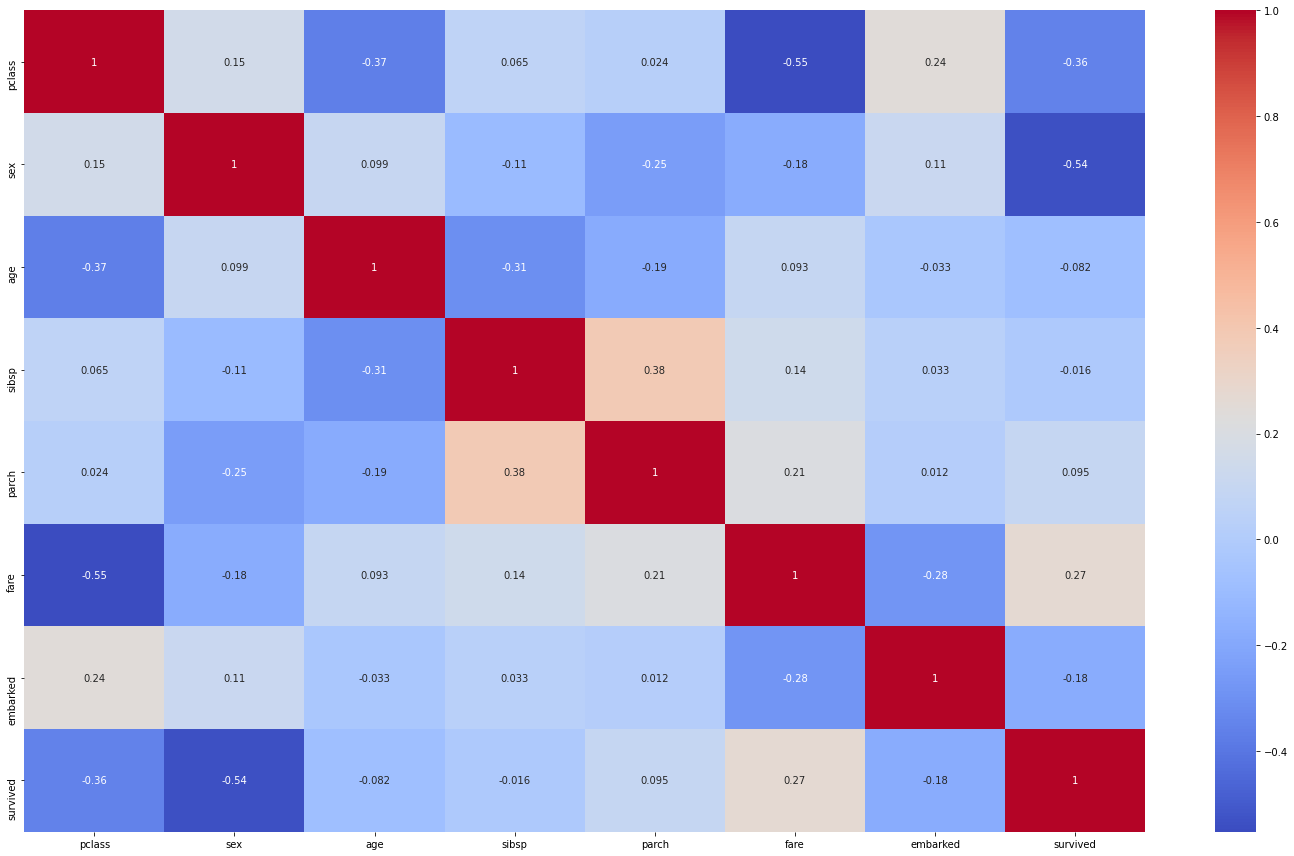

In [170]:
subset = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'survived']]

corr_matrix = subset.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [172]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)


In [173]:
X_train.shape[1]

7

In [174]:

class TitanicNN(nn.Module):
    def __init__(self, input_dim):
       super(TitanicNN, self).__init__()
       self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
)

    def forward(self, x):
        return self.net(x)


input_dim = X_train.shape[1]
model = TitanicNN(input_dim)



In [175]:
class TitanicNN(nn.Module):
    def __init__(self, input_dim):
       super(TitanicNN, self).__init__()
       self.fc1 = nn.Linear(input_dim, 32)
       self.fc2 = nn.Linear(32, 64)
       self.fc3 = nn.ReLU()
       self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)


        return x


input_dim = X_train.shape[1]
model = TitanicNN(input_dim)

In [176]:
# Loss funct 
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [177]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')


Epoch [1/100], Loss: 21.5094
Epoch [2/100], Loss: 17.3555
Epoch [3/100], Loss: 16.0998
Epoch [4/100], Loss: 15.6721
Epoch [5/100], Loss: 15.3393
Epoch [6/100], Loss: 15.1729
Epoch [7/100], Loss: 15.0933
Epoch [8/100], Loss: 14.7940
Epoch [9/100], Loss: 14.8618
Epoch [10/100], Loss: 14.5774
Epoch [11/100], Loss: 14.6544
Epoch [12/100], Loss: 14.5839
Epoch [13/100], Loss: 14.3614
Epoch [14/100], Loss: 14.4526
Epoch [15/100], Loss: 14.2247
Epoch [16/100], Loss: 14.0945
Epoch [17/100], Loss: 14.1982
Epoch [18/100], Loss: 14.1827
Epoch [19/100], Loss: 13.9804
Epoch [20/100], Loss: 13.8481
Epoch [21/100], Loss: 13.8663
Epoch [22/100], Loss: 13.8376
Epoch [23/100], Loss: 13.9205
Epoch [24/100], Loss: 13.8541
Epoch [25/100], Loss: 13.9712
Epoch [26/100], Loss: 13.8136
Epoch [27/100], Loss: 13.8283
Epoch [28/100], Loss: 13.7391
Epoch [29/100], Loss: 13.6816
Epoch [30/100], Loss: 13.8526
Epoch [31/100], Loss: 13.5050
Epoch [32/100], Loss: 13.5769
Epoch [33/100], Loss: 13.6914
Epoch [34/100], Los

In [178]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        predictions = (torch.sigmoid(outputs) >= 0.5).float()
        correct += (predictions == yb).sum().item()
        total += yb.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 80.42%


This is good accuracy, but we ANNs are black boxes and we can't really see which features are driving the outcome. So, lets try a Decision tree

In [179]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree


In [203]:
from sklearn.tree import DecisionTreeClassifier


X_train_np = X_train_tensor.numpy()
y_train_np = y_train_tensor.numpy().ravel()
X_test_np = X_test_tensor.numpy()
y_test_np = y_test_tensor.numpy().ravel()


clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train_np, y_train_np)

from sklearn.metrics import classification_report

y_pred = clf.predict(X_test_np)

print(classification_report(y_test_np, y_pred))



              precision    recall  f1-score   support

         0.0       0.70      0.95      0.80        80
         1.0       0.88      0.48      0.62        63

    accuracy                           0.74       143
   macro avg       0.79      0.71      0.71       143
weighted avg       0.78      0.74      0.72       143



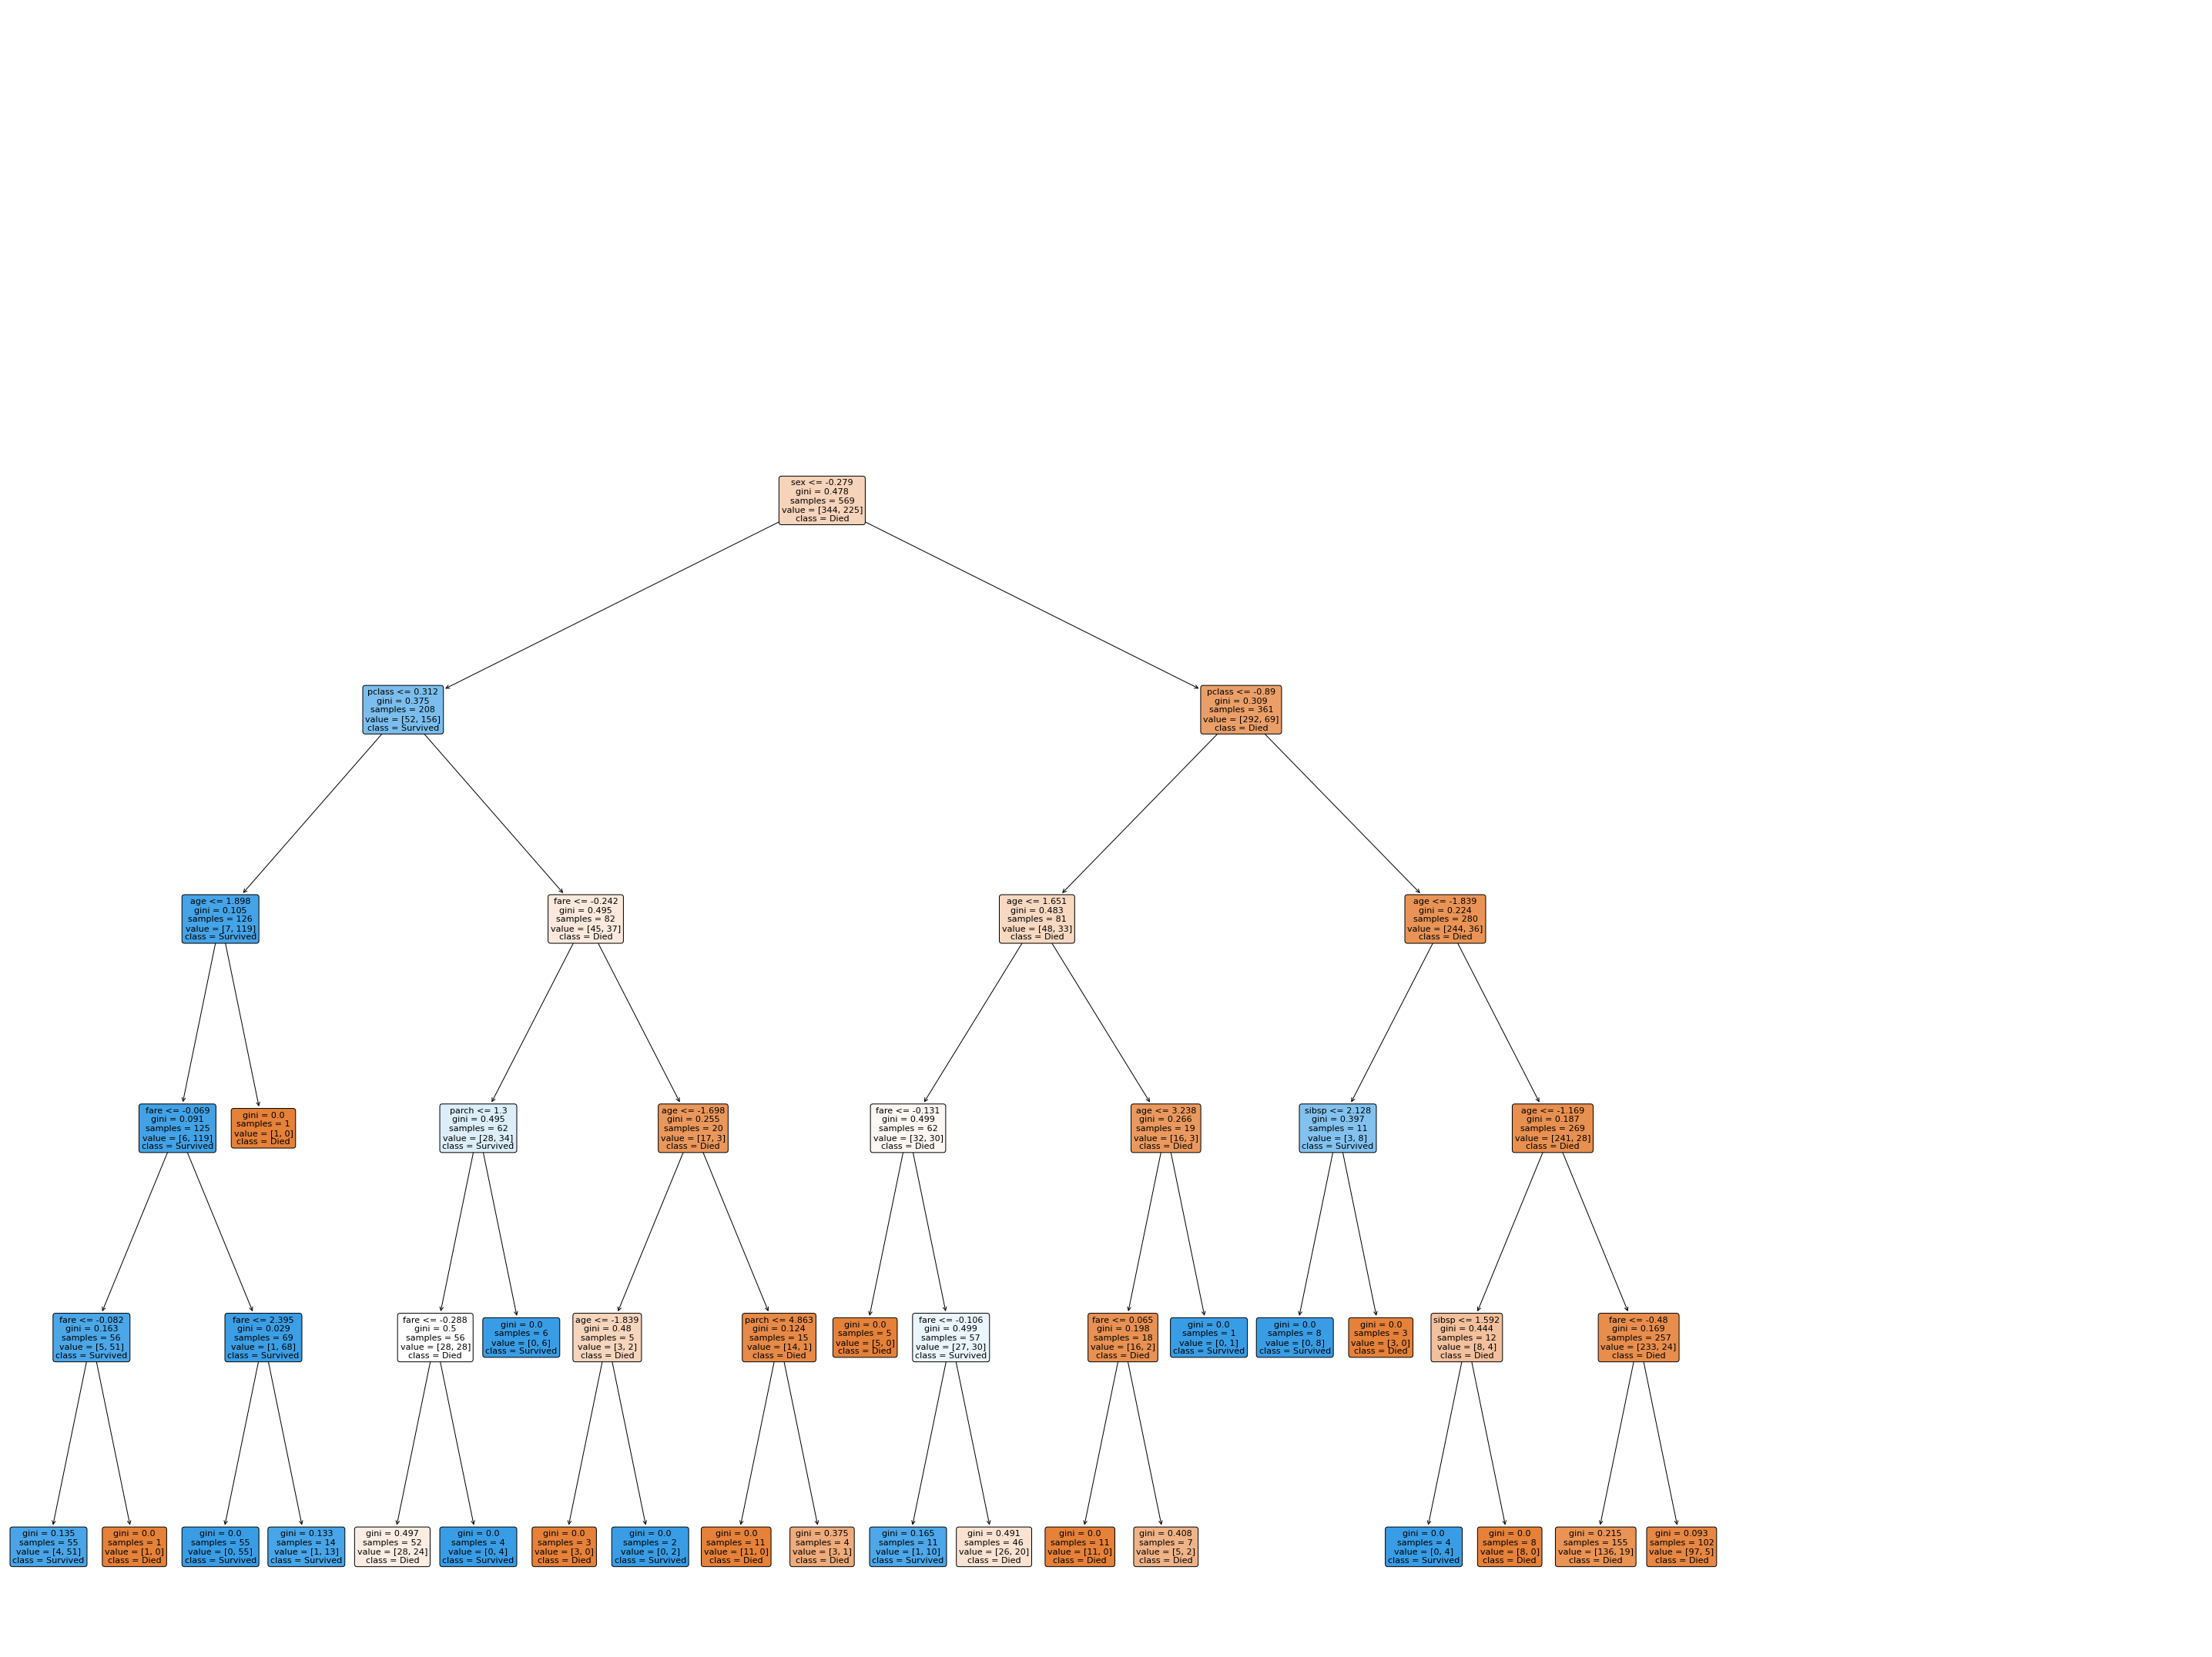

In [204]:
plt.figure(figsize=(40, 30))
tree.plot_tree(clf, 
               feature_names=['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked'], 
               class_names=['Died', 'Survived'],
               filled=True,
               rounded=True)
plt.show()


    Feature  Importance
1       sex    0.498690
0    pclass    0.205309
2       age    0.115837
5      fare    0.102890
3     sibsp    0.058663
4     parch    0.018611
6  embarked    0.000000


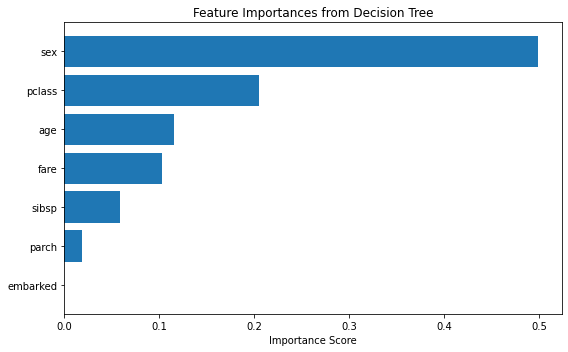

In [205]:
feature_names = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']


importances = clf.feature_importances_

feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importances)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(feat_importances['Feature'], feat_importances['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importances from Decision Tree')
plt.gca().invert_yaxis()
plt.show()

What about Causal Discovery?

Depth=2, working on node 7: 100%|██████████| 8/8 [00:00<00:00, 573.27it/s] 

PC Algo


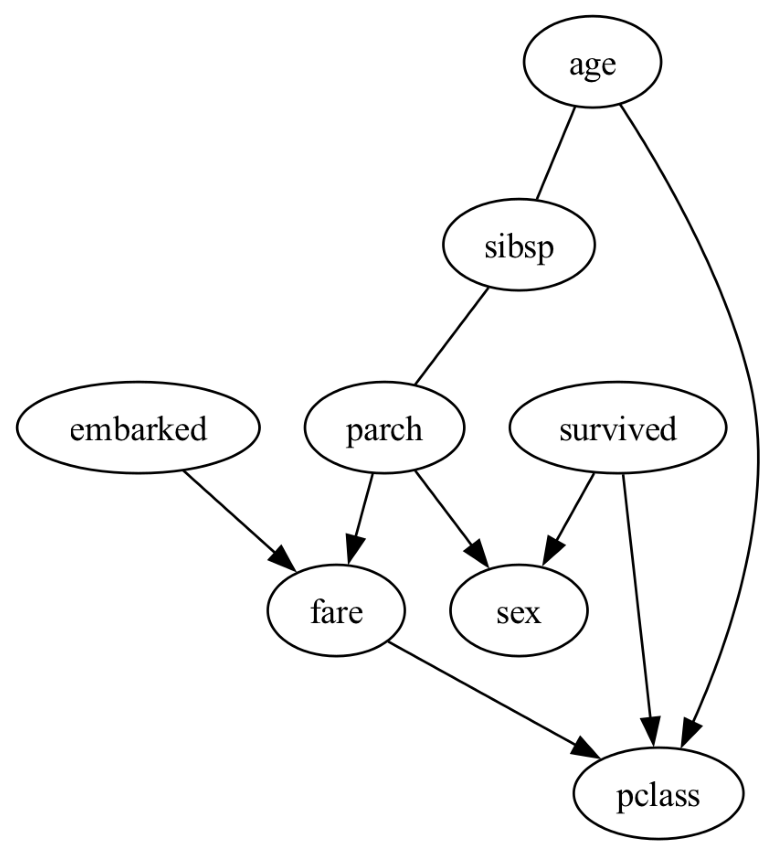

In [191]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.cit import fisherz, chisq
import matplotlib.pyplot as plt
from causallearn.utils.GraphUtils import GraphUtils
from IPython.display import Image, display
import pandas as pd

all_features = pd.concat([X, y], axis=1)


X_np = all_features.to_numpy()
col_names = list(all_features.columns)


print("PC Algo")
cg_pc = pc(X_np, alpha=0.01, ci_test=fisherz,  node_names=col_names)


cg_pc.draw_pydot_graph()

In [193]:
print("_______FCI_______")
cg_fci, sep_set = fci(X_np, alpha=0.05, ci_test="fisherz",  node_names=col_names)
pdy = GraphUtils.to_pydot(cg_fci)
pdy.write_png("fci_graph_titanic.png")

Depth=0, working on node 7: 100%|██████████| 8/8 [00:00<00:00, 382.98it/s]

_______FCI_______
pclass --> fare
sibsp --> age
parch --> sibsp


Can we intervene?

In [ ]:
import pandas as pd
import dice_ml
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder


subset = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'survived']].dropna()
for col in ['sex', 'embarked']:
    subset[col] = LabelEncoder().fit_transform(subset[col])


X = subset.drop('survived', axis=1)
clf = DecisionTreeClassifier(max_depth=4, random_state=42).fit(X, subset['survived'])


dice = dice_ml.Dice(
    dice_ml.Data(dataframe=subset, continuous_features=['age', 'fare'], outcome_name='survived'),
    dice_ml.Model(model=clf, backend="sklearn")
)


query = pd.DataFrame([[3, 0, 22, 1, 0, 7.25, 0]], columns=X.columns)
dice_exp = dice.generate_counterfactuals(
    query, 
    total_CFs=5, 
    desired_class="opposite",
    features_to_vary=['sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
)
dice_exp.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00, 10.59it/s]

Query instance (original outcome : 0)


,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,3,0,22,1,0,7.25,0,0



Diverse Counterfactual set (new outcome: 1)


,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,3,0,8,1,0,7.25,0,1
1,3,0,3,5,0,7.25,0,1
2,3,0,1,1,0,7.25,0,1
3,3,0,13,1,0,7.25,0,1
4,3,1,1,1,0,7.25,0,1
